# Open-shell

## Currently, open-shell calculations support only linear mixing in SCF optimization.
## Can do geometry optimization but not MD.
## Will be fixed soon.

In [10]:
import sys
sys.path.insert(1, "/home/maxim/Projects/git2/PYSEQM_dev/")

import torch
import seqm
from seqm.seqm_functions.constants import Constants
from seqm.seqm_functions.make_dm_guess import make_dm_guess
import matplotlib.pyplot as plt

from seqm.Molecule import Molecule
from seqm.ElectronicStructure import Electronic_Structure
import numpy as np
from seqm.seqm_functions.read_xyz import read_xyz
from seqm.MolecularDynamics import Geometry_Optimization_SD

DTYPE = torch.float64
torch.set_default_dtype(DTYPE)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device = torch.device('cpu')

# Carbene (CH2) and O2, triplets

In [25]:
species = torch.as_tensor([
                            [6,1,1],
                            [8,8,0]
                          ], dtype=torch.int64, device=device)

coordinates = torch.tensor([
                            [[ 1.2437e-01,  4.4651e-02,  1.7825e-01],
                             [ 1.1301e+00, -3.9041e-02, -1.5585e-01],
                             [-5.6454e-01,  2.4138e-01,  9.6361e-01]],

                            [[ 1.9663e-04,  3.0676e-04, -1.0761e-03],
                             [ 3.0337e-04,  9.3247e-05,  1.1676e+00],
                             [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]
    
                            ], device=device)

const = Constants().to(device)

elements = [0]+sorted(set(species.reshape(-1).tolist()))

seqm_parameters = {
                   'method' : 'PM3',
                   'scf_eps' : 1.0e-6,  # unit eV, change of electric energy, as nuclear energy doesnt' change during SCF
                   'scf_converger' : [0,0.5], # converger used for scf loop
                   'sp2' : [False, 1.0e-5],  # whether to use sp2 algorithm in scf loop,
                   'elements' : elements, #[0,1,6,8],
                   'learned' : [], # learned parameters name list, e.g ['U_ss']
                   'pair_outer_cutoff' : 1.0e10, # consistent with the unit on coordinates
                   'eig' : True,
                   'scf_backward' : 0,
                   'UHF' : True, ### use unrestricted HF
                   }

# specify charges and multiplicity
charges = torch.tensor([0,0],dtype=torch.int64, device=device)
mult = torch.tensor([3,3], device=device)

molecule = Molecule(const, seqm_parameters, coordinates, species, charges, mult).to(device)

In [18]:
# optimize geometry
opt =  Geometry_Optimization_SD(seqm_parameters, alpha=0.002, force_tol=1.0e-2, max_evl=400).to(device)
max_force, dE =  opt.run(molecule)

Step,  Max_Force,      Etot(eV),     dE(eV)
1      1.240424e-02 ||3.106370e+00 3.106370e+00 ||-1.812874e-01 -1.812874e-01 
2      1.240370e-02 ||3.106369e+00 -1.023533e-06 ||-1.812878e-01 -3.990707e-07 
3      1.237618e-02 ||3.106368e+00 -9.693262e-07 ||-1.812877e-01 2.534443e-08 
4      1.215040e-02 ||3.106367e+00 -8.987652e-07 ||-1.812880e-01 -2.690333e-07 
5      1.214668e-02 ||3.106366e+00 -9.161870e-07 ||-1.812880e-01 4.560388e-08 
6      1.192769e-02 ||3.106365e+00 -8.628552e-07 ||-1.812879e-01 8.527309e-08 
7      1.192929e-02 ||3.106364e+00 -8.808334e-07 ||-1.812880e-01 -1.253107e-07 
8      1.171359e-02 ||3.106363e+00 -8.326412e-07 ||-1.812881e-01 -4.996275e-08 
9      1.171539e-02 ||3.106363e+00 -8.499014e-07 ||-1.812880e-01 1.034607e-07 
10      1.150270e-02 ||3.106362e+00 -8.045193e-07 ||-1.812881e-01 -1.139786e-07 
11      1.150379e-02 ||3.106361e+00 -8.208544e-07 ||-1.812881e-01 -9.975452e-09 
12      1.129457e-02 ||3.106360e+00 -7.776447e-07 ||-1.812880e-01 4.943013e-08 

In [28]:
# Total energy
molecule.Etot

tensor([-146.1992, -584.0310])

## Compare with energies of singlets

In [29]:
coordinates = torch.tensor([
                            [[-2.2974e-02, -7.9243e-03, -3.1638e-02],
                             [ 1.0669e+00,  9.8889e-03,  3.9484e-02],
                             [-3.5404e-01,  2.4503e-01,  9.7816e-01]],

                            [[ 1.9159e-04,  3.1941e-04, -1.4933e-03],
                             [ 3.0841e-04,  8.0601e-05,  1.1680e+00],
                             [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]
    
                            ], device=device)

charges = torch.tensor([0,0],dtype=torch.int64, device=device)
mult = torch.tensor([1,1], device=device)

molecule = Molecule(const, seqm_parameters, coordinates, species, charges, mult).to(device)


In [31]:
opt =  Geometry_Optimization_SD(seqm_parameters, alpha=0.01, force_tol=1.0e-2, max_evl=400).to(device)
max_force, dE =  opt.run(molecule)

Step,  Max_Force,      Etot(eV),     dE(eV)
1      8.329278e-03 ||4.909875e+00 4.909875e+00 ||7.971809e-01 7.971809e-01 
converged with 1 step, Max Force = 8.329278e-03 (eV/Ang), dE = 2.853528e+00 (eV)


In [33]:
# Energies of singlets are higher than energies of triplets, as expected
molecule.Etot

tensor([-144.3957, -583.0526])

# Open-shell singlet
### H2 and HF separation
### The symmetry needs to be broken. Otherwise, closed-shell solution.
### Calculations will take a while because of linear mixing which is not the most efficient SCF optimization algorythm. Adaptive mixing for open shells will be added soon.

In [34]:
# array of bond lengths
bond_l = np.linspace(0.7, 10.0, 41)

species = torch.as_tensor([
                       [1,1],
                       [9,1],
                            ],
                      dtype=torch.int64, device=device)
const = Constants().to(device)
elements = [0]+sorted(set(species.reshape(-1).tolist()))
charges = torch.tensor([0,0],dtype=torch.int64, device=device)

### Broken symmetry open-shell.

In [42]:
seqm.seqm_functions.scf_loop.debug=False
seqm.seqm_functions.scf_loop.MAX_ITER = 1500


# arrays to record energies and charges
E_os_break = np.array([[0,0]])
Q_os_break = np.array([[[0,0],[0,0]]])

for i in bond_l:
    print(i)
    coordinates = torch.tensor([
                              [
                               [ 0.00,    0.00,    0.00],
                               [ 0.00,    0.00,    i],
                              ],
                              [
                               [0.00,    0.00,    0.00],
                               [0.00,    0.00,    i],
                              ],
                            ], device=device)
    
    seqm_parameters = {
                   'method' : 'PM3',  # AM1, MNDO, PM#
                   'scf_eps' : 2.0e-5,  # unit eV, change of electric energy, as nuclear energy doesnt' change during SCF
                   'scf_converger' : [0,0.96], # converger used for scf loop
                                         # [0, 0.1], [0, alpha] constant mixing, P = alpha*P + (1.0-alpha)*Pnew
                                         # [1], adaptive mixing
                                         # [2], adaptive mixing, then pulay
                   'sp2' : [False, 1.0e-5],  # whether to use sp2 algorithm in scf loop,
                                            #[True, eps] or [False], eps for SP2 conve criteria
                   'elements' : elements, #[0,1,6,8],
                   'learned' : [], # learned parameters name list, e.g ['U_ss']
                   #'parameter_file_dir' : '../seqm/params/', # file directory for other required parameters
                   'pair_outer_cutoff' : 1.0e10, # consistent with the unit on coordinates
                   'eig' : True,
                   'scf_backward' : 0,
                   'UHF' : True, # use unrestricted HF
                   }
    
    mult = torch.tensor([1,1], device=device)
    molecule = Molecule(const, seqm_parameters, coordinates, species, charges, mult).to(device)
    
    ### Break the symmetry of a DM guess: HOMO_alpha = 0.9*HOMO + 0.1*LUMO   (mix_coeff=0.1)
    make_dm_guess(molecule, seqm_parameters, mix_homo_lumo=True, mix_coeff=0.1, overwrite_existing_dm=True);
    
    # Single point calculation with the current bond length
    esdriver = Electronic_Structure(seqm_parameters).to(device)
    esdriver(molecule, P0=molecule.dm)
    
    E_os_break = np.vstack((E_os_break,molecule.Etot.cpu().numpy()))
    Q_os_break = np.vstack((Q_os_break,[molecule.q.cpu().numpy()]))
    
E_os_break = E_os_break[1:]
Q_os_break = Q_os_break[1:]

0.7
0.9325
1.165
1.3975
1.63
1.8625
2.0949999999999998
2.3275
2.56
2.7925000000000004
3.0250000000000004
3.2575000000000003
3.49
3.7225
3.955
4.1875
4.42
4.6525
4.885000000000001
5.117500000000001
5.3500000000000005
5.5825000000000005
5.815
6.0475
6.28
6.5125
6.745
6.977500000000001
7.210000000000001
7.442500000000001
7.675000000000001
7.907500000000001
8.14
8.3725
8.605
8.8375
9.07
9.3025
9.535
9.7675
10.0


###  Closed-shell (equivalent to open-shell without breaking the symetry).

In [43]:
E_cs = np.array([[0,0]])
Q_cs = np.array([[[0,0],[0,0]]])

dm=None
for i in bond_l:
    print(i)
    coordinates = torch.tensor([
                              [[ 0.00,    0.00,    0.00],
                               [ 0.00,    0.00,    i]],
        
                              [[0.00,    0.00,    0.00],
                               [0.00,    0.00,    i]],
                            ], device=device)
    
    
    seqm_parameters = {
                   'method' : 'PM3',  # AM1, MNDO, PM#
                   'scf_eps' : 2.0e-5,  # unit eV, change of electric energy, as nuclear energy doesnt' change during SCF
                   'scf_converger' : [0,0.96], # converger used for scf loop
                                         # [0, 0.1], [0, alpha] constant mixing, P = alpha*P + (1.0-alpha)*Pnew
                                         # [1], adaptive mixing
                                         # [2], adaptive mixing, then pulay
                   'sp2' : [False, 1.0e-5],  # whether to use sp2 algorithm in scf loop,
                                            #[True, eps] or [False], eps for SP2 conve criteria
                   'elements' : elements, #[0,1,6,8],
                   'learned' : [], # learned parameters name list, e.g ['U_ss']
                   #'parameter_file_dir' : '../seqm/params/', # file directory for other required parameters
                   'pair_outer_cutoff' : 1.0e10, # consistent with the unit on coordinates
                   'eig' : True,
                   'scf_backward' : 0,
                   'UHF' : False, # use unrestricted HF
                   }
    
    mult = 1
    molecule = Molecule(const, seqm_parameters, coordinates, species, charges, mult).to(device)
    esdriver = Electronic_Structure(seqm_parameters).to(device)
    esdriver(molecule)
    E_cs = np.vstack((E_cs,molecule.Etot.cpu().numpy()))
    Q_cs = np.vstack((Q_cs,[molecule.q.cpu().numpy()]))

E_cs = E_cs[1:]
Q_cs = Q_cs[1:]

0.7
0.9325
1.165
1.3975
1.63
1.8625
2.0949999999999998
2.3275
2.56
2.7925000000000004
3.0250000000000004
3.2575000000000003
3.49
3.7225
3.955
4.1875
4.42
4.6525
4.885000000000001
5.117500000000001
5.3500000000000005
5.5825000000000005
5.815
6.0475
6.28
6.5125
6.745
6.977500000000001
7.210000000000001
7.442500000000001
7.675000000000001
7.907500000000001
8.14
8.3725
8.605
8.8375
9.07
9.3025
9.535
9.7675
10.0


### H2 separation energy curve.

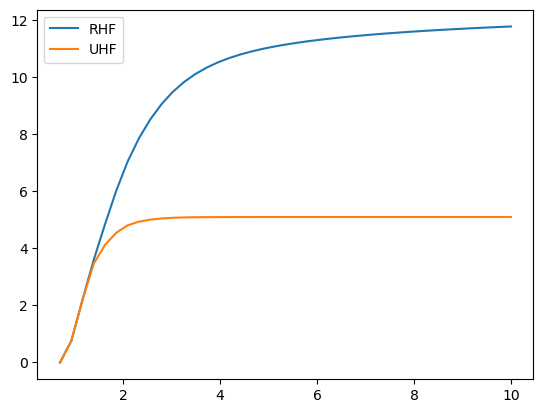

In [44]:
plt.plot(bond_l, E_cs[:,0] - min(E_cs[:,0]), label='RHF')
plt.plot(bond_l, E_os_break[:,0] - min(E_os_break[:,0]), label='UHF')
plt.legend()

### HF separation energy curve.

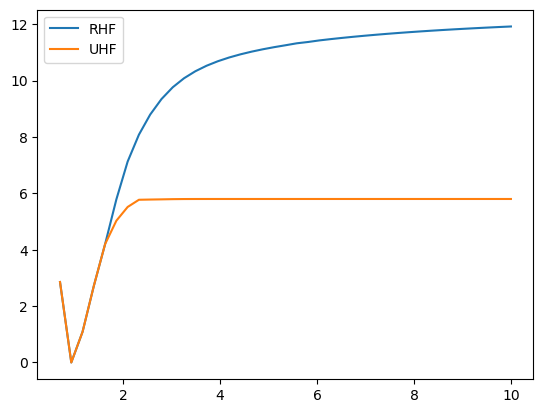

In [45]:
plt.plot(bond_l, E_cs[:,1]-min(E_cs[:,1]), label='RHF')
plt.plot(bond_l, E_os_break[:,1] - min(E_os_break[:,1]), label='UHF')
#plt.plot(E_os_break_reuse_dm[:,1])
plt.legend()

### Charges on F and H at 0.93 Å (equilibrium) distance.

#### Broken symmetry open-shell singlet

In [47]:
# F                    H
Q_os_break[:,1,0][1], Q_os_break[:,1,1][1]

(-0.1651833519837571, 0.16519613817030337)

#### Closed-shell singlet

In [48]:
# F                    H
Q_cs[:,1,0][1], Q_cs[:,1,1][1]

(-0.16502516327662242, 0.16502516327662187)

### Charges on F and H at 10 Å distance.

#### Broken symmetry open-shell singlet. Almost zero (homolytic separation), which is correct.

In [49]:
# F                    H
Q_os_break[:,1,0][-1], Q_os_break[:,1,1][-1]

(-1.0888147075505117e-05, 1.5496246730233638e-05)

#### Closed-shell singlet. Non-zero charges, which is incorrect. In gas phase, separation shoud proceed homolytically.

In [50]:
# F                    H
Q_cs[:,1,0][-1], Q_cs[:,1,1][-1]

(-0.2920764818165722, 0.29207648181656987)